<h2>Build a SAS DLPy model with Functional API</h2>

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import swat
import sys
import dlpy
from dlpy.network import *
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import ImageTable
from dlpy.sequential import Sequential

This tutorial assumes that you are already familiar with the Seqential API. The tutorial would introduce an alternate way, Functional API which is very similar to Keras functional API. 

The reason we have it is that Functional API provides you with a more flexiable way to implement complex models. Seqential API is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs(multiple outputs will be supported after VIYA 3.4). 

In [2]:
host_name='your_host_name'
port_number='your_port_number'
sess = swat.CAS(host_name, port_number)

To use the Functional API, create your input and output tensors and then pass them to the Model() function. 

Here's a good example for the Functional API: models with multiple inputs and outputs. Let's consider the following model. We define two tensors, grayscale image and RGB image, by Input() which return a Tensor object. The grayscale image is feeded into two convolutional branchs. The model will also have another input, color image. Then a convolutional operation is used for extracting feature of the image. By far all of features are ready. Three tensors are concatenated and then used by OutputLayer_1 to calculate a classification loss. Also the model is supervised via OutputLayer_2.

In [3]:
input1 = Input(n_channels = 1, width = 28, height = 28)
input2 = Input(n_channels = 3, width = 28, height = 28)
conv1 = Conv2d(2, name='conv1')(Conv2d(2, name='conv0')(input1))
conv2 = Conv2d(2, name='conv2')(input1)
conv3 = Conv2d(2, name='conv3')(input2)
output2 = OutputLayer(n=2)(conv3)
concat1 = Concat()([conv1, conv2, conv3])
output1 = OutputLayer(n=2)(concat1)

Pass defined input tensors and output tensors to the Model() function. Then call compile() to compile the network.

In [4]:
model1 = Model(conn = sess, inputs = [input1, input2], outputs = [output1, output2])
model1.compile()
model1.print_summary()

NOTE: Model compiled successfully.


,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,InputLayer_1,input,,,None,"(28, 28, 1)","(0, 0)"
1,4,conv0,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(18, 2)"
2,5,conv1,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(36, 2)"
3,3,conv2,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(18, 2)"
4,1,InputLayer_2,input,,,None,"(28, 28, 3)","(0, 0)"
5,2,conv3,convo,"(3, 3)",1,Relu,"(28, 28, 2)","(54, 2)"
6,6,Concat_1,concat,,,Auto,"(28, 28, 6)","(0, 0)"
7,7,OutputLayer_2,output,"(4704, 2)",,Softmax,2,"(9408, 2)"
8,8,OutputLayer_1,output,"(1568, 2)",,Softmax,2,"(3136, 2)"
9,,,,,,,,12682


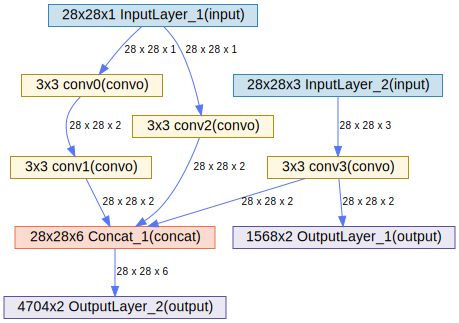

In [5]:
model1.plot_network()

<h3>Build ResNet like network<a name="configureIt"></a></h3>

In the next model, let's consider how to build a residual block.

In [6]:
def conv_block(x, filters, size, stride=1, mode='same', act=True):
    x = Conv2d(filters, size, size, act='identity', include_bias=False, stride=stride)(x)
    x = BN(act='relu' if act else 'identity')(x)
    return x

In [7]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, 2)
    x = conv_block(x, nf, 3, 1, act=False)
    return Res()([x, ip])

In [8]:
inp_resnet= Input(3, 112, 112, scale = 1.0 / 255, name='InputLayer_1')
x=conv_block(inp_resnet, 64, 9, 1)
for i in range(4): x=res_block(x)
x=Conv2d(20, 9, 9, act='tanh')(x)
x=Pooling(7, 7)(x)
output = OutputLayer(n=2)(x)
resnet_like_model = Model(sess, inputs = inp_resnet, outputs = output)
resnet_like_model.compile()

NOTE: Model compiled successfully.


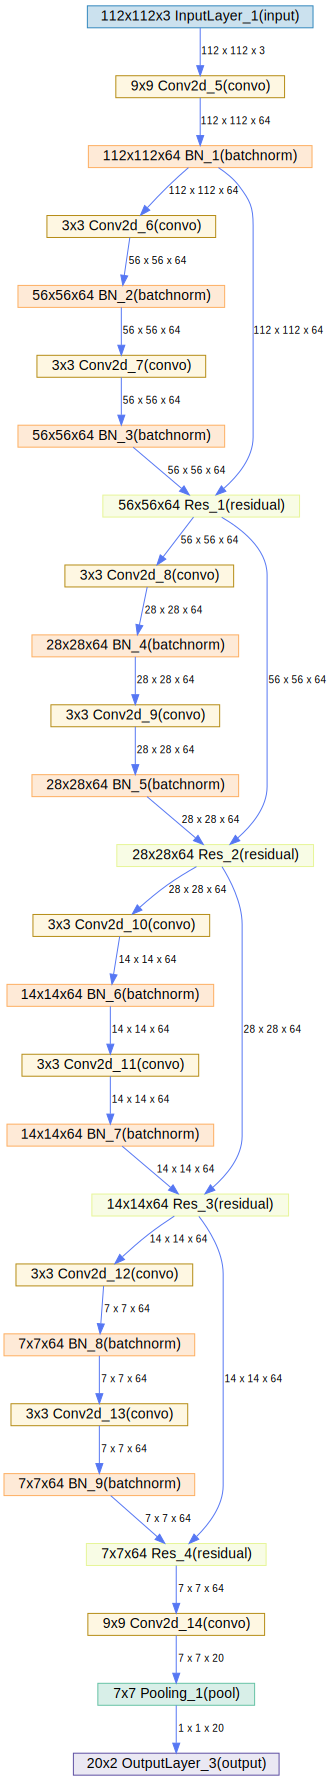

In [9]:
resnet_like_model.plot_network()

This model can be trained just like sequential models.

In [10]:
img_path='/disk/linux/dlpy/Giraffe_Dolphin'
my_images = ImageTable.load_files(sess, path=img_path)
my_images.resize(112)

In [11]:
resnet_like_model.fit(data=my_images, n_threads=4, record_seed=13309,
                      mini_batch_size=2, 
                      max_epochs=50, 
                      lr=0.0001, 
                      gpu=Gpu(devices=[1]), 
                      log_level=2)

NOTE: Inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Using 1 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 113.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.97 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 2.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 8.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001          0.6864     0.4351     0.33
NOTE:  1        0.0001          0.6847     0.4423     0.26
NOTE:  2

,Descr,Value
0,Model Name,model_fairgj
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


<h3>Convert a Sequential or a model table into a functional model<a name="configureIt"></a></h3>

Let's create a sequential model.

In [12]:
sequential_model = Sequential(sess, model_table='Simple_CNN')
sequential_model.add(InputLayer(3, 224, 224))
sequential_model.add(Conv2d(8, 7))
sequential_model.add(Pooling(2))
sequential_model.add(Conv2d(8, 7))
sequential_model.add(Pooling(2))
sequential_model.add(Dense(16))
sequential_model.add(OutputLayer(act='softmax', n=2))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


To convert the sequential model into a functional model, it can be achieved by calling to_functional_model().

In [13]:
functional_model = sequential_model.to_functional_model()

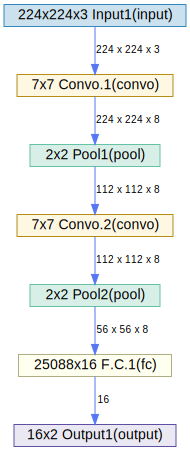

In [14]:
functional_model.plot_network()

<h3>Load a pretrained model and do transfer learning<a name="configureIt"></a></h3>

In [15]:
ResNet18 = Model(conn=sess)

In [16]:
ResNet18.load(path = '/path/to/RESNET18_CAFFE.sashdat')

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "resnet18_caffe" according to the model name in the table.
NOTE: RESNET18_CAFFE_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: RESNET18_CAFFE_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


In [17]:
feature_extractor = ResNet18.to_functional_model(stop_layers=ResNet18.layers[-1])

In [18]:
inp = Input(**feature_extractor.layers[0].config)
x = feature_extractor(inp)
output = OutputLayer(n=10)(x)
keypoints = Keypoints(n=20)(x)
multi_out = Model(sess, inp, [output, keypoints])
multi_out.compile()

NOTE: Model compiled successfully.


Use ResNet18 weights as pretrained weights

In [19]:
multi_out.set_weights(ResNet18.model_weights)

NOTE: Model weights attached successfully!


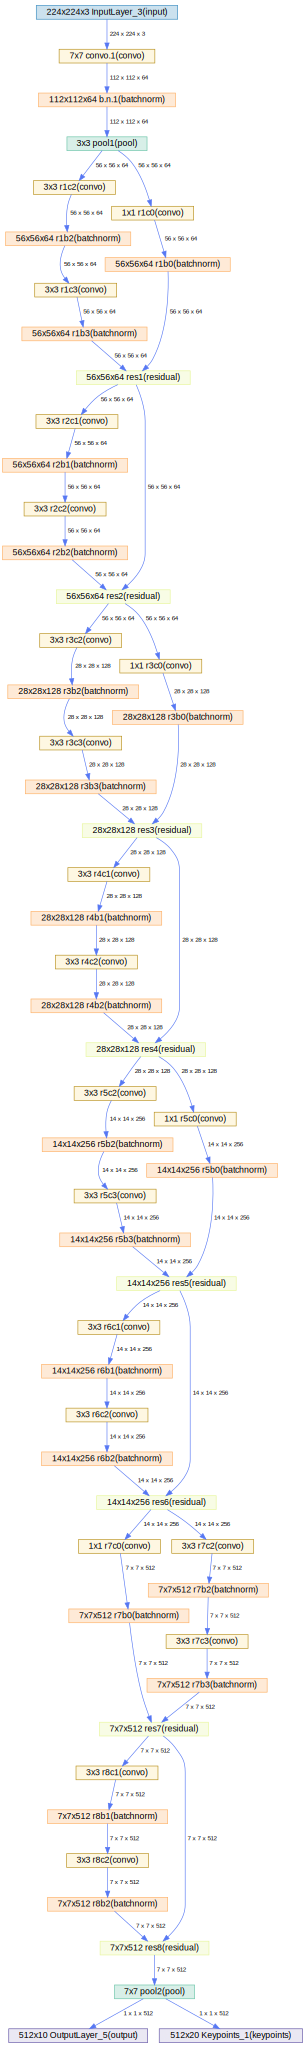

In [20]:
multi_out.plot_network()

In [21]:
sess.endsession()

+ Elapsed: 0.000122s, sys: 0.000116s, mem: 0.194mb